In [100]:
import pandas as pd
import numpy as np
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [101]:
con = sqlite3.connect("../db.sqlite3")
pd.read_sql("SELECT restaurant_order.datetime, restaurant_orderitem.quantity, restaurant_product.price,  restaurant_product.name FROM restaurant_order INNER JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id INNER JOIN restaurant_product ON restaurant_product.id = restaurant_orderitem.product_id", con).to_csv(r"data.csv", index=False)
df = pd.read_csv("data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.shape

(74818, 4)

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<AxesSubplot: title={'center': 'Top 10 position in menu be quantity'}, ylabel='Quantity'>

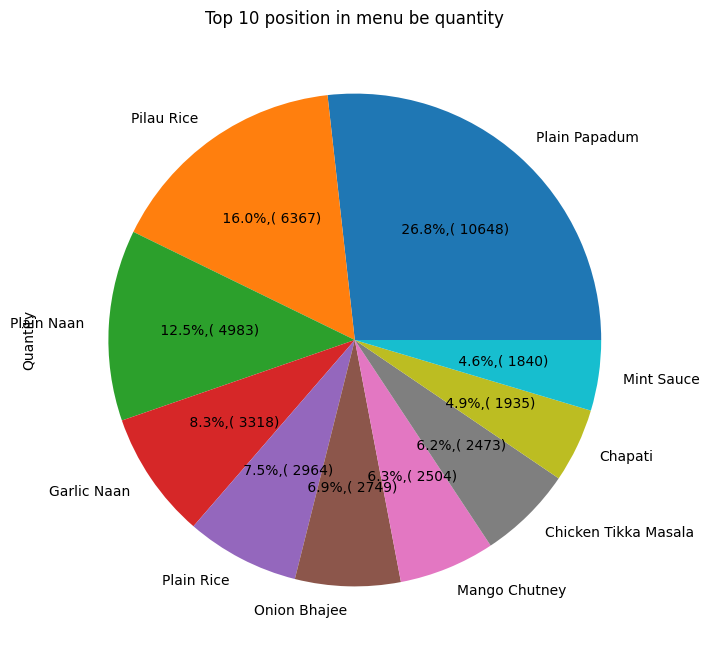

In [102]:
quantitys = df.groupby("name")["quantity"].sum().sort_values(ascending=False)[:10]
quantitys.plot.pie(figsize=(10, 8), ylabel="Quantity", title="Top 10 position in menu be quantity",  autopct=lambda p:f"{p: .1f}%,({p*sum(quantitys)/100: .0f})")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<AxesSubplot: title={'center': 'Top 10 products which make the most money for restaurant'}, ylabel='Money'>

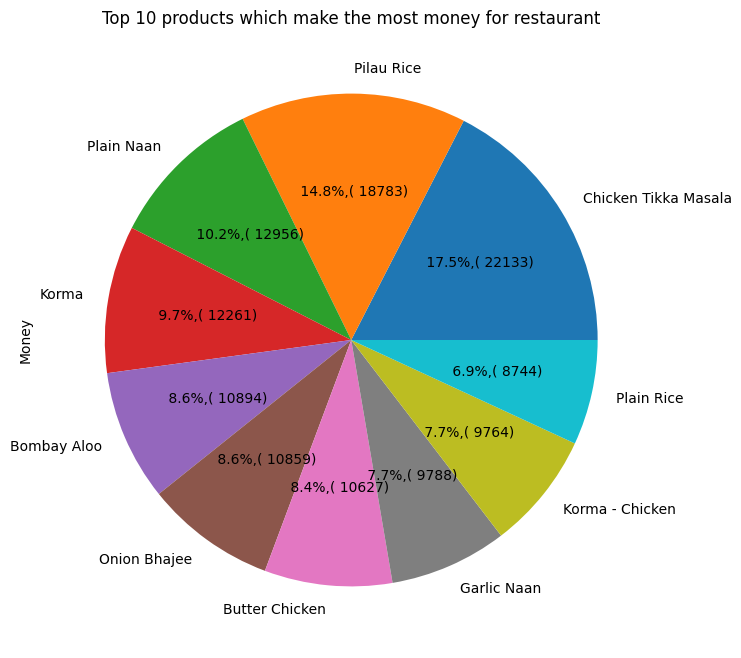

In [103]:
df["money"] = df["quantity"] * df["price"]
all_money = df.groupby("name")["money"].sum().sort_values(ascending=False)[:10]
all_money.plot.pie(figsize=(10, 8), ylabel="Money", title="Top 10 products which make the most money for restaurant",  autopct=lambda p:f"{p: .1f}%,({p*sum(all_money)/100: .0f})")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<AxesSubplot: title={'center': 'Best hour for order'}, xlabel='Order hour', ylabel='Income'>

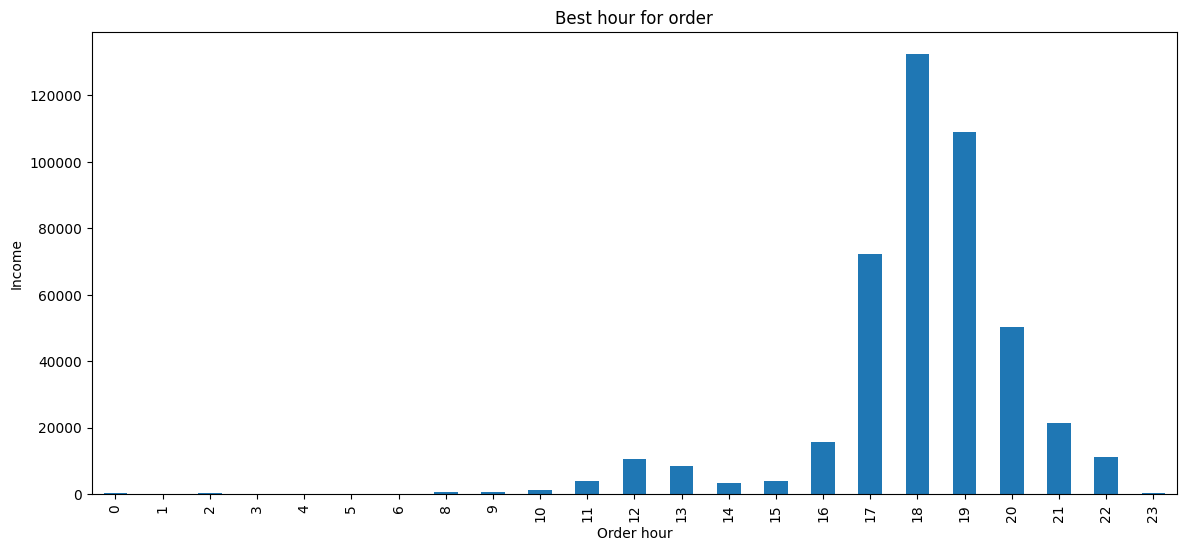

In [141]:
df["Order hour"] = pd.DatetimeIndex(df["datetime"]).hour
df.groupby("Order hour")["money"].sum().plot.bar(title="Best hour for order", ylabel="Income", figsize=(14, 6))

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<AxesSubplot: title={'center': 'Best day of week for order'}, xlabel='Day of week', ylabel='Income'>

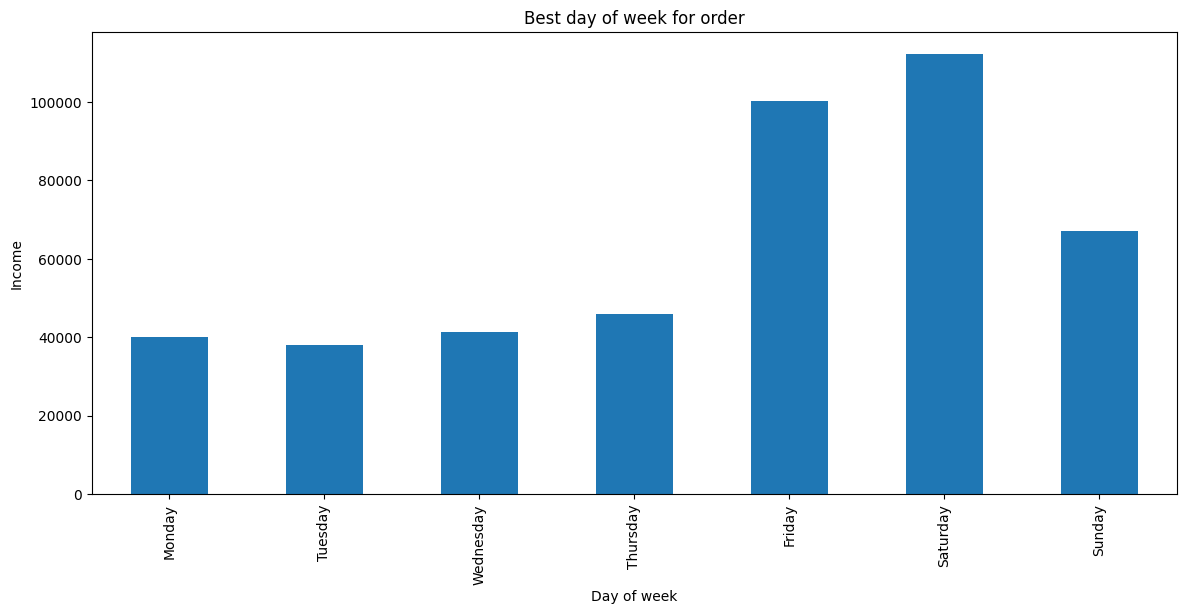

In [139]:
sorter = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Day of week"] = df["datetime"].dt.day_name()
df.groupby("Day of week")["money"].sum().reindex(sorter).plot.bar(title="Best day of week for order", ylabel="Income", figsize=(14, 6))